In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# For clustering and regression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# For association analysis
from mlxtend.frequent_patterns import apriori, association_rules






In [47]:

df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'DateTime': ['Date', 'Time']}, 
                 infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'])

cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
        'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 
        'Sub_metering_3']
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.dropna(inplace=True)

df.set_index('DateTime', inplace=True)

print(df.head())

/var/folders/yy/9r218vq56vd3602bpbtz_tgw0000gn/T/ipykernel_93572/394776456.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('household_power_consumption.txt', sep=';',
/var/folders/yy/9r218vq56vd3602bpbtz_tgw0000gn/T/ipykernel_93572/394776456.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('household_power_consumption.txt', sep=';',


                     Global_active_power  Global_reactive_power  Voltage  \
DateTime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
DateTime                                                                
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00          

/var/folders/yy/9r218vq56vd3602bpbtz_tgw0000gn/T/ipykernel_93572/394776456.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('household_power_consumption.txt', sep=';',


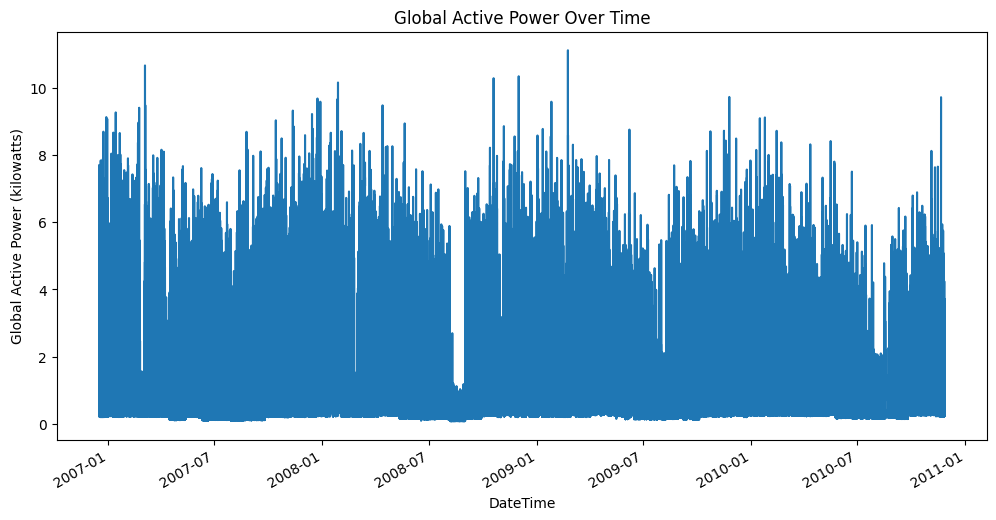

In [48]:
# Plot Global Active Power over time
plt.figure(figsize=(12, 6))
df['Global_active_power'].plot()
plt.xlabel('DateTime')
plt.ylabel('Global Active Power (kilowatts)')
plt.title('Global Active Power Over Time')
plt.show()

/var/folders/yy/9r218vq56vd3602bpbtz_tgw0000gn/T/ipykernel_93572/2108674919.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H').mean()


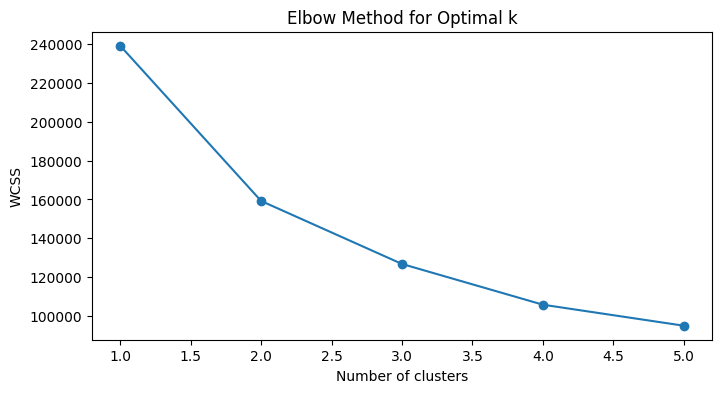

In [49]:
# Resample data to hourly means
df_hourly = df.resample('H').mean()

# Handle missing values by dropping them
df_hourly.dropna(inplace=True)

# Prepare data for clustering
features = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
            'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 
            'Sub_metering_3']
X = df_hourly[features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters using the elbow method
wcss = []
for i in range(1, 6):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 4))
plt.plot(range(1, 6), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [50]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)
df_hourly['Cluster'] = kmeans.labels_

# Analyze cluster centers
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_df = pd.DataFrame(cluster_centers, columns=features)
print(cluster_df)

   Global_active_power  Global_reactive_power     Voltage  Global_intensity  \
0             2.994986               0.230531  238.267178         12.746165   
1             1.791329               0.120819  239.642326          7.494002   
2             0.514024               0.113770  241.754152          2.227150   

   Sub_metering_1  Sub_metering_2  Sub_metering_3  
0        8.374728       11.865747       11.498021  
1        1.322608        0.713863       14.615510  
2        0.233168        0.471571        1.571196  


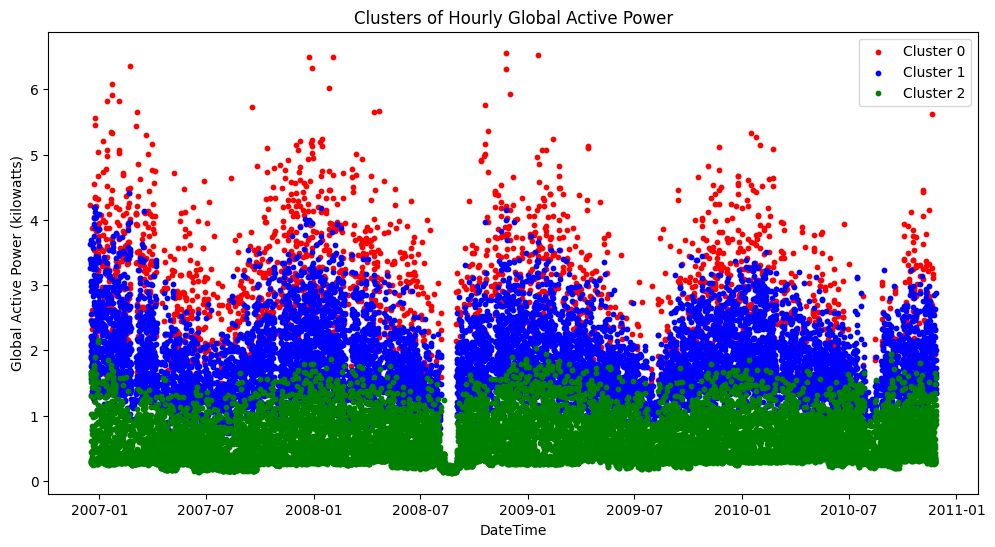

In [51]:
# Plot clusters over time
plt.figure(figsize=(12, 6))
colors = {0: 'red', 1: 'blue', 2: 'green'}
for cluster in df_hourly['Cluster'].unique():
    cluster_data = df_hourly[df_hourly['Cluster'] == cluster]
    plt.scatter(cluster_data.index, cluster_data['Global_active_power'], 
                color=colors[cluster], label=f'Cluster {cluster}', s=10)
plt.xlabel('DateTime')
plt.ylabel('Global Active Power (kilowatts)')
plt.title('Clusters of Hourly Global Active Power')
plt.legend()
plt.show()

In [52]:
# Prepare data for regression
X_reg = df[['Global_reactive_power', 'Voltage', 'Global_intensity', 
            'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]
y_reg = df['Global_active_power']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, 
                                                    test_size=0.2, random_state=42)

# Build regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Evaluate the model
y_pred = regressor.predict(X_test)
from sklearn.metrics import r2_score, mean_squared_error

print('R^2 Score:', r2_score(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))

R^2 Score: 0.9985500910441268
Mean Squared Error: 0.0016296157203171894


In [40]:
# Binarize sub-metering data
df_assoc = df[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].copy()
df_assoc = df_assoc.applymap(lambda x: 1 if x > 0 else 0)

/var/folders/yy/9r218vq56vd3602bpbtz_tgw0000gn/T/ipykernel_93572/3238890706.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_assoc = df_assoc.applymap(lambda x: 1 if x > 0 else 0)


In [53]:
# Count individual item frequencies
item_support = {}
transactions = df_assoc.values.tolist()
num_transactions = len(transactions)

# Count support for single items
for col in df_assoc.columns:
    support = df_assoc[col].sum() / num_transactions
    item_support[frozenset([col])] = support

# Define minimum support threshold
min_support = 0.01

# Filter out items below min_support
freq_items = {item: support for item, support in item_support.items() if support >= min_support}

# Count support for item pairs
pair_support = {}
from itertools import combinations

for transaction in transactions:
    items_in_transaction = [df_assoc.columns[i] for i, val in enumerate(transaction) if val == 1]
    for pair in combinations(items_in_transaction, 2):
        pair = frozenset(pair)
        if pair in pair_support:
            pair_support[pair] += 1
        else:
            pair_support[pair] = 1

# Convert counts to support
pair_support = {pair: count / num_transactions for pair, count in pair_support.items()}

# Filter out pairs below min_support
freq_pairs = {pair: support for pair, support in pair_support.items() if support >= min_support}

In [54]:
rules = []

for pair in freq_pairs:
    items = list(pair)
    for antecedent in items:
        consequent = [item for item in items if item != antecedent][0]
        antecedent_support = freq_items[frozenset([antecedent])]
        pair_support_value = freq_pairs[pair]
        confidence = pair_support_value / antecedent_support
        lift = confidence / freq_items[frozenset([consequent])]
        if confidence >= 0.5:  # Minimum confidence threshold
            rule = {
                'antecedent': antecedent,
                'consequent': consequent,
                'support': pair_support_value,
                'confidence': confidence,
                'lift': lift
            }
            rules.append(rule)

In [55]:
# Convert rules to DataFrame
rules_df = pd.DataFrame(rules)

# Sort rules by confidence
rules_df.sort_values(by='confidence', ascending=False, inplace=True)

# Display the rules
print(rules_df[['antecedent', 'consequent', 'support', 'confidence', 'lift']])

       antecedent      consequent   support  confidence      lift
1  Sub_metering_1  Sub_metering_3  0.063565    0.770308  1.318571
0  Sub_metering_2  Sub_metering_3  0.185656    0.621213  1.063358
